# Multiple Ring Neurons Experiment

## Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import datetime as dt
import os

In [2]:
COLORS = mcolors.TABLEAU_COLORS
COLORS = list(COLORS.values())

## Equations

### Output Transform Function (Sigmoid)
$$z_{r}=f(v_{i})=\frac{1}{1+e^{-\beta (v_{i} - \mu)}}$$
$$\beta = ??; \mu = ??$$

In [3]:
def sigmoid(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

### New Equations

Activation: 

$\frac{dv_i}{dt}=\frac{1}{\tau}(-\lambda u_i v_i + I_i' (1 - \alpha \sum\limits_{\substack{j \in R \\ j \ne i}}z_j));$

$I_i' = I_i - f(\varphi\sum\limits_{t_c=t_0}^{t}z_i(t_c))$

$f(x) = \frac{1}{1 + e^{-\beta(x - \mu)}}$

Deactivation: 

$\frac{du_i}{dt}=-\rho u_i + \gamma \frac{z_i}{c_i + \epsilon};$

Output: 

$z_i=f(v_i)=\frac{1}{1+e^{-\beta (v_i - \mu)}};$

In [79]:
def doodle(t, state, p):
    '''
    Because we can't provide a vectorized state (i.e. state can't be 2-d in solve_ivp()),
    we hide the two vectors in state, so state is a vector of [v, u], 
    where v and u are both vectors of length `num_units`.
    
    Then, we can handle the change in v and change in u separately, 
    and concat them back together to be returned as the new state.
    '''
    v = state[0:p['N']]
    u = state[p['N']:2*p['N']]
    I_prime = state[2*p['N']:]
    print(I_prime)

    assert set([v.shape[0], u.shape[0], I_prime.shape[0]]) == set([p['N']]), f"State's shapes don't match! {v.shape, u.shape, I_prime.shape}"

    z = sigmoid(v, p['beta'], p['mu'])
   
    # calculate dv/dt and du/dt
    inhibition_vec = 1 - (p['alpha'] * np.dot(z, 1 - np.eye(p['N']))) # multiply by the sum of *other* neuron's outputs
    dv = (1 / p['tau']) * ((-1 * p['lambda'] * u * v) + (I_prime * inhibition_vec))
    du = (-1 * p['rho'] * u) + (p['gamma'] * (z) / (p['c'] + p['epsilon']))
    dI_prime = -1 * p['phi'] * p['I'] * z
    
    # join v and u back together to be returned
    return np.array((dv, du, dI_prime)).reshape(3*p['N'])

### Plot all variables on one plot

[0.4 0.8 0.2]
[0.39999997 0.79999995 0.19999999]
[0.39999949 0.79999898 0.19999974]
[0.39999923 0.79999845 0.19999962]
[0.39999793 0.79999579 0.19999897]
[0.39999769 0.79999531 0.19999886]
[0.3999974  0.7999947  0.19999871]
[0.3999974  0.7999947  0.19999871]
[0.3999921  0.79998369 0.19999611]
[0.39998899 0.7999762  0.1999947 ]
[0.39997271 0.79993467 0.19998749]
[0.39996952 0.79992597 0.19998614]
[0.39996533 0.79991369 0.19998442]
[0.39996528 0.79991297 0.19998442]
[0.39993052 0.7998083  0.19997025]
[0.39989766 0.79964503 0.19996028]
[0.39968803 0.79820135 0.19990519]
[0.39964508 0.79819213 0.19989374]
[0.399566   0.79726809 0.19987763]
[0.39954367 0.79633092 0.19987661]
[0.39931987 0.79337277 0.19983369]
[0.39910885 0.78946981 0.1998035 ]
[0.39838099 0.76789889 0.19968889]
[0.39864919 0.76021307 0.19971192]
[0.39830829 0.75522278 0.19967218]
[0.39769707 0.76009918 0.19960604]
[0.39706216 0.74700936 0.19952458]
[0.39669775 0.74016044 0.19948256]
[0.39496332 0.70702442 0.19928378]
[0.394

Text(0.5, 0, 't')

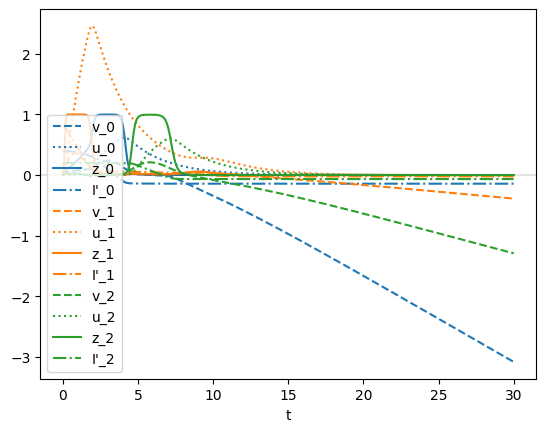

In [84]:
t = np.linspace(0, 30, 300)

v = np.array([0.0, 0.0, 0.0])
u = np.array([0.0, 0.0, 0.0])
I = np.array([0.4, 0.8, 0.2])
c = np.array([0.5, 0.9, 0.5])

params = {
    'N': 3,
    'tau': 1.0,
    'lambda': 1,
    'alpha': 0.9,
    'I': I,
    'rho': 0.4,
    'gamma': 0.2,
    'c': c,
    'epsilon': 0.00001,
    'beta': 50.0,
    'mu': 0.1,
    'phi': 0.5
}

state = np.array((v, u, I)).reshape(3*params['N'])
result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(min(t), max(t)), t_eval=t, y0=state)
v_series = result.y[:params['N'],]
z_series = sigmoid(v_series, params['beta'], params['mu'])
u_series = result.y[params['N']:2*params['N'],]
I_prime_series = result.y[2*params['N']:,]
print(np.max(z_series))
fig,ax = plt.subplots()
for i in range(params['N']):
    color = COLORS[i]
    ax.plot(t, v_series[i], label=f'v_{i}', c=color, linestyle='dashed')
    ax.plot(t, u_series[i], label=f'u_{i}', c=color, linestyle='dotted')
    ax.plot(t, z_series[i], label=f'z_{i}', c=color, linestyle='solid')
    ax.plot(t, I_prime_series[i], label=f"I'_{i}", c=color, linestyle='dashdot')
    ax.axhline(y=0.0, c="black", linewidth=0.05)

ax.legend()
# ax.set_ylim([0, 1])
ax.set_xlabel('t')


### Plot all variables on multiple plots

In [ ]:
t = np.linspace(0, 50, 500)

v = np.array([0.0, 0.0, 0.0])
u = np.array([0.0, 0.0, 0.0])
I = np.array([0.4, 0.8, 0.2])
c = np.array([0.5, 0.9, 0.5])

params = {
    'N': 3,
    'tau': 1.0,
    'lambda': 10,
    'alpha': 0.9,
    'I': I,
    'rho': 0.8,
    'gamma': 0.8,
    'c': c,
    'epsilon': 0.00001,
    'beta': 50.0,
    'mu': 0.1,
    'phi': 4
}

state = np.array((v, u, I)).reshape(3*params['N'])
result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(min(t), max(t)), t_eval=t, y0=state)
v_series = result.y[:params['N'],]
z_series = sigmoid(v_series, params['beta'], params['mu'])
u_series = result.y[params['N']:2*params['N'],]
I_prime_series = result.y[2*params['N']:,]

fig, axes = plt.subplots(2,2)
for i in range(params['N']):
    color = COLORS[i]
    axes[0][0].plot(t, v_series[i], label=f'v_{i}', c=color, linestyle='dashed')
    axes[1][0].plot(t, u_series[i], label=f'u_{i}', c=color, linestyle='dotted')
    axes[0][1].plot(t, z_series[i], label=f'z_{i}', c=color, linestyle='solid')
    axes[1][1].plot(t, I_prime_series[i], label=f"I'_{i}", c=color, linestyle='dashdot')

for ax in axes.flatten():
    ax.set_ylim([0, 1])
    ax.legend()
    ax.set_xlabel('t')